In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import torchvision.datasets as datasets  
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
print(len(training_data))
print(len(test_data))

60000
10000


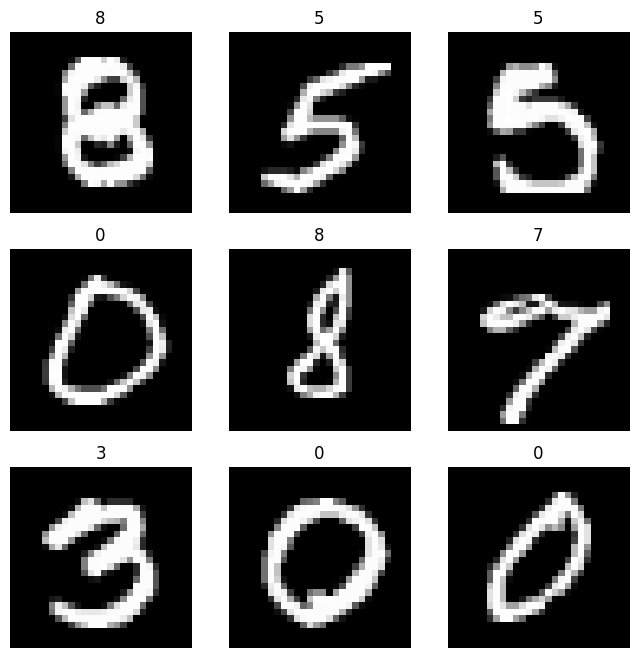

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(str(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, z_dim, h_dim=200):
        super().__init__()
        # encoder
        self.img_2hid = nn.Linear(input_dim, h_dim)

        # one for mu and one for stds, note how we only output
        # diagonal values of covariance matrix. Here we assume
        # the pixels are conditionally independent 
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)

        # decoder
        self.z_2hid = nn.Linear(z_dim, h_dim)
        self.hid_2img = nn.Linear(h_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.img_2hid(x))
        mu = self.hid_2mu(h)
        sigma = self.hid_2sigma(h)
        return mu, sigma

    def decode(self, z):
        new_h = F.relu(self.z_2hid(z))
        x = torch.sigmoid(self.hid_2img(new_h))
        return x

    def forward(self, x):
        mu, sigma = self.encode(x)
        sigma = torch.exp(sigma)

        # Sample from latent distribution from encoder
        epsilon = torch.randn_like(sigma)
        z_reparametrized = mu + sigma*epsilon

        x = self.decode(z_reparametrized)
        return x, mu, sigma


In [6]:
# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
INPUT_DIM = 784
Z_DIM = 20
H_DIM = 200
NUM_EPOCHS = 10
BATCH_SIZE = 32
LR_RATE = 3e-4

cpu


In [7]:
train_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
# Define train function
def train(num_epochs, model, optimizer, loss_fn):
    # Start training
    for epoch in range(num_epochs):
        loop = tqdm(enumerate(train_loader))
        for i, (x, y) in loop:
            # Forward pass
            x = x.to(device).view(-1, INPUT_DIM)
            x_reconst, mu, sigma = model(x)

            # loss, formulas from https://www.youtube.com/watch?v=igP03FXZqgo&t=2182s
            reconst_loss = loss_fn(x_reconst, x)
            kl_div = - torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

            # Backprop and optimize
            loss = reconst_loss + kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())


In [9]:
# Initialize model, optimizer, loss
model = VariationalAutoEncoder(INPUT_DIM, Z_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.BCELoss(reduction="sum")

In [10]:
# Run training
train(NUM_EPOCHS, model, optimizer, loss_fn)

313it [00:04, 75.84it/s, loss=3.3e+3] 
313it [00:04, 76.96it/s, loss=3.25e+3]
313it [00:03, 80.05it/s, loss=2.85e+3]
313it [00:03, 79.48it/s, loss=2.8e+3] 
313it [00:03, 80.38it/s, loss=2.67e+3]
313it [00:03, 78.73it/s, loss=2.64e+3]
313it [00:03, 79.40it/s, loss=2.23e+3]
313it [00:03, 81.67it/s, loss=2.03e+3]
313it [00:03, 82.83it/s, loss=2.44e+3]
313it [00:04, 73.81it/s, loss=2.39e+3]


In [11]:
# Get Mu's and Sigma's for each image
mus = []
sigmas = []
for image,label in test_data:
    with torch.no_grad():
        mu, sigma = model.encode(image.view(1, 784))
        mus.append(mu)
        sigmas.append(torch.exp(sigma))

In [12]:
print(len(mus))
print(len(sigmas))

10000
10000


In [13]:
mus[0].shape

torch.Size([1, 20])

In [14]:
mus[1]

tensor([[ 0.4483,  0.7978,  0.8354, -0.6010, -1.1342,  0.1125,  1.1652, -1.0292,
          0.2948,  0.3206, -0.2848, -1.0317,  0.2302, -1.1610, -0.2617, -0.9089,
         -1.1529,  1.9778, -0.2612,  0.2896]])

In [15]:
sigmas[1]

tensor([[0.8608, 0.6883, 0.6505, 0.4347, 0.5290, 0.8700, 0.3535, 0.3760, 0.5646,
         0.4852, 0.7342, 0.3922, 0.4553, 0.5778, 0.2606, 0.6969, 0.4808, 0.4077,
         0.6771, 0.5492]])

In [18]:
import pandas as pd
import seaborn as sns
import numpy as np

In [20]:
np.array(mus[1]).reshape((20,))

array([ 0.4482668 ,  0.7978339 ,  0.8353624 , -0.6009829 , -1.1342432 ,
        0.11247578,  1.1651504 , -1.0292068 ,  0.2947501 ,  0.32064903,
       -0.28479135, -1.0316771 ,  0.23015423, -1.160998  , -0.26167187,
       -0.9089074 , -1.1529063 ,  1.9778079 , -0.26124305,  0.28964883],
      dtype=float32)

In [27]:
rows = []
labels = []
for i,(image,label) in enumerate(test_data):
    labels.append(label)
    rows.append(pd.Series(np.array(mus[i]).reshape((20,)),name='image%d' % i))

df = pd.concat(rows,join='inner',axis=1).transpose()
print(df.shape)
labels = pd.Series(labels,index=df.index)
df = pd.concat([df,labels],join='inner',axis=1)
df.columns = ['latent'+str(i) for i in df.columns[:-1]] + ['Label']
print(df)

(10000, 20)
            latent0   latent1   latent2   latent3   latent4   latent5  \
image0    -0.453913 -0.244044  1.028566  0.585393  0.600123 -0.166813   
image1     0.448267  0.797834  0.835362 -0.600983 -1.134243  0.112476   
image2     0.125480 -0.101504  0.458813 -0.373239  1.421990 -0.069780   
image3    -0.513448  0.133279  0.881033  0.684009 -1.153539 -0.548196   
image4    -0.272217 -0.710655 -0.612745  1.470347 -0.213053 -0.475853   
...             ...       ...       ...       ...       ...       ...   
image9995  0.069836  0.309571  1.398621 -2.256213  1.083134  0.166520   
image9996 -0.239451  0.736645  1.438809 -1.415883 -0.887208  0.300702   
image9997 -0.060049 -0.006796 -0.070201  0.672396  2.354964  0.052475   
image9998  0.103754  0.709605  0.179864 -0.134127 -0.413167 -0.137635   
image9999  0.050684 -0.046106 -0.817671  0.550891 -1.184250  0.132839   

            latent6   latent7   latent8   latent9  ...  latent11  latent12  \
image0    -2.127138  0.721824 -0.

In [33]:
from sklearn.manifold import TSNE
embedding = TSNE(perplexity=20,metric='euclidean').fit_transform(df.iloc[:,:-1])
embedding = pd.DataFrame(embedding,index=df.index,columns=['TSNE1','TSNE2'])
df2 = pd.concat([embedding,df['Label']],join='inner',axis=1)
print(df2)

               TSNE1      TSNE2  Label
image0     21.498314 -70.176460      7
image1     56.116299  15.724757      2
image2     68.729103 -24.703949      1
image3    -17.414930  67.090378      0
image4    -39.345871 -35.463921      4
...              ...        ...    ...
image9995  40.331112  14.613218      2
image9996  21.117304  55.636215      3
image9997  -7.749718 -35.270061      4
image9998 -25.718250   3.979212      5
image9999 -62.990128  14.886498      6

[10000 rows x 3 columns]


<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

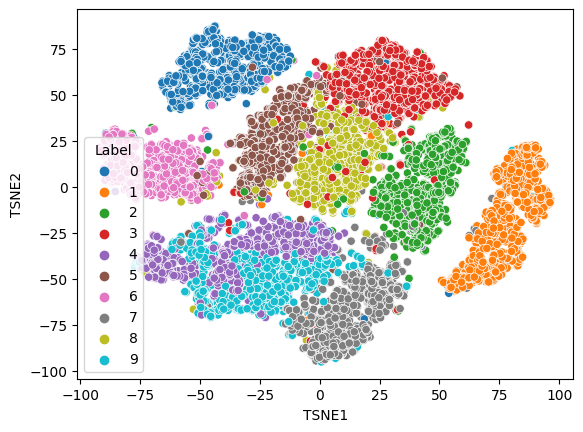

In [34]:
df3 = df2.copy()
df3['Label'] = df3['Label'].astype('category')
sns.scatterplot(x='TSNE1',y='TSNE2',hue='Label',data=df3)

<AxesSubplot:xlabel='latent0', ylabel='latent1'>

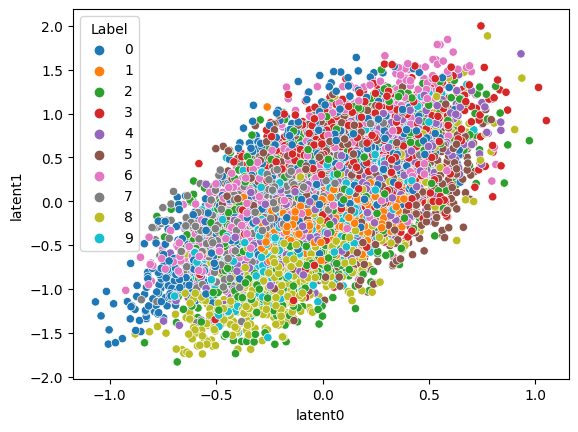

In [37]:
df4 = df.copy()
df4['Label'] = df4['Label'].astype('category')
sns.scatterplot(x='latent0',y='latent1',hue='Label',data=df4)

torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])


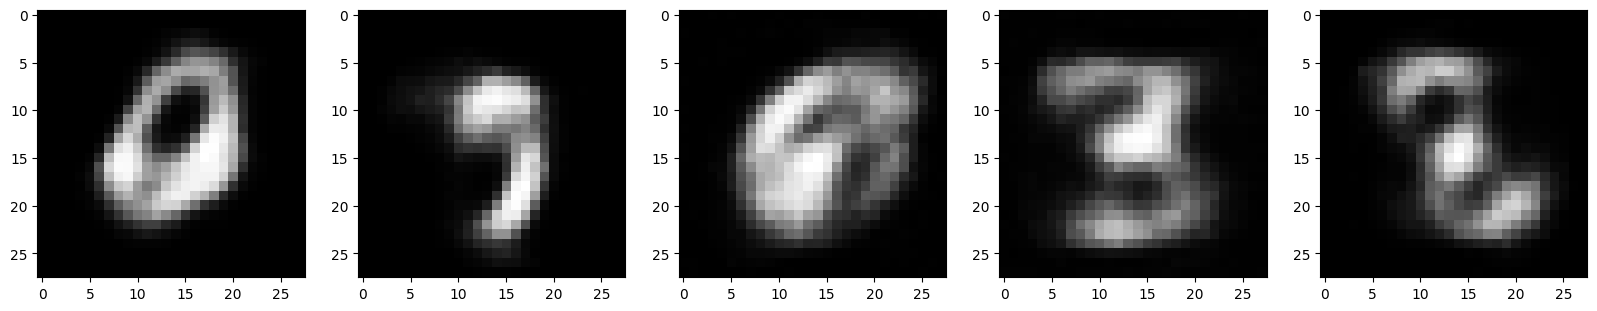

In [46]:
fig,axes = plt.subplots(1,5,figsize=(20,4))
for i in range(5):
    z = torch.randn_like(mus[0])
    with torch.no_grad():
        image = model.decode(z)
        image = image.reshape((28,28))
        print(image.shape)
        axes[i].imshow(image.numpy(),cmap='gist_gray')